In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from numpy import sqrt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample

In [2]:
datos_pacientes = pd.read_csv("./data/Datos_Limpios_Lab1.csv")

In [3]:
data = datos_pacientes.copy()

In [4]:
data["Date of Service"] = pd.to_datetime(data["Date of Service"], errors="coerce", dayfirst=True)

data["Date of Service"] = data["Date of Service"].dt.strftime("%Y-%m-%d")

# Ordenar por Id y Fecha
data = data.sort_values(["Patient ID", "Date of Service"])

# Para cada Id nos quedamos con el registro más reciente
data = data.drop_duplicates(subset="Patient ID", keep="last")

C:\Users\scast\AppData\Local\Temp\ipykernel_7940\3045502807.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Date of Service"] = pd.to_datetime(data["Date of Service"], errors="coerce", dayfirst=True)


In [5]:
target = "CVD Risk Score"
X = data.drop(columns=[target])
y = data[target]

In [6]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1)

In [7]:
X_train.shape, y_train.shape

((1078, 41), (1078,))

In [8]:
X_test.shape, y_test.shape

((270, 41), (270,))

In [11]:
cols_to_drop = ["Id", "Fecha", "CodigoPostal"]

def drop_columns(df):
    return df.drop(columns=cols_to_drop, errors="ignore")

dropper = FunctionTransformer(drop_columns)

### 1. Modelo de Regresión Polinomial

## Objetivo
Construir un pipeline que incluya generación de características polinomiales y regresión lineal, explorando diferentes grados de polinomios y estrategias de escalamiento para identificar el punto de sobreajuste.

In [12]:
# Configurar el estilo de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [13]:
cols_to_drop = ['Patient ID', 'Date of Service',]

def drop_columns(df):
    return df.drop(columns=cols_to_drop, errors="ignore")

dropper = FunctionTransformer(drop_columns)

In [14]:
numeric_features = [
    'Age', 'Weight (kg)', 'Height (m)', 'BMI', 'Abdominal Circumference (cm)', 
    'Total Cholesterol (mg/dL)', 'HDL (mg/dL)', 'Fasting Blood Sugar (mg/dL)', 
    'Height (cm)', 'Waist-to-Height Ratio', 'Systolic BP', 'Diastolic BP', 
    'Estimated LDL (mg/dL)', 'BMI_Age', 'BMI_Systolic', 'Age_Cholesterol', 
    'Systolic_Diastolic', 'Total Cholesterol (mg/dL)_log', 
    'Fasting Blood Sugar (mg/dL)_log', 'BMI_log', 'Age_squared', 'BMI_squared', 
    'Systolic BP_squared', 'Cholesterol_HDL_Ratio', 'Mean_Arterial_Pressure', 
    'Pulse_Pressure', 'Atherogenic_Index', 'Glucose_HDL_Ratio', 'BMI_Age_Adjusted', 
    'Pulse_Pressure_Age_Adjusted', 'Ponderal_Index', 'BP_Load', 'WHR_Squared', 
    'Lipid_Risk_Index'
]

categorical_features = [ 
    'Sex', 'Smoking Status', 'Diabetes Status', 'Physical Activity Level', 
    'Family History of CVD'
]

print(f"Características numéricas: {numeric_features}")
print(f"Características categóricas: {categorical_features}")  
print(f"Total: {len(numeric_features) + len(categorical_features)} características")

Características numéricas: ['Age', 'Weight (kg)', 'Height (m)', 'BMI', 'Abdominal Circumference (cm)', 'Total Cholesterol (mg/dL)', 'HDL (mg/dL)', 'Fasting Blood Sugar (mg/dL)', 'Height (cm)', 'Waist-to-Height Ratio', 'Systolic BP', 'Diastolic BP', 'Estimated LDL (mg/dL)', 'BMI_Age', 'BMI_Systolic', 'Age_Cholesterol', 'Systolic_Diastolic', 'Total Cholesterol (mg/dL)_log', 'Fasting Blood Sugar (mg/dL)_log', 'BMI_log', 'Age_squared', 'BMI_squared', 'Systolic BP_squared', 'Cholesterol_HDL_Ratio', 'Mean_Arterial_Pressure', 'Pulse_Pressure', 'Atherogenic_Index', 'Glucose_HDL_Ratio', 'BMI_Age_Adjusted', 'Pulse_Pressure_Age_Adjusted', 'Ponderal_Index', 'BP_Load', 'WHR_Squared', 'Lipid_Risk_Index']
Características categóricas: ['Sex', 'Smoking Status', 'Diabetes Status', 'Physical Activity Level', 'Family History of CVD']
Total: 39 características


In [15]:
numeric_transforme_polinomial = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("polynomial", PolynomialFeatures(degree=2)),
    ]
)

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
])

In [16]:
preprocessor_polinomial = ColumnTransformer(
    transformers=[
        ("num", numeric_transforme_polinomial, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [17]:
pipeline_regresion_polinomial = Pipeline(steps=[
    ("dropper", dropper),
    ("preprocesamiento", preprocessor_polinomial),
    ("modelo", LinearRegression()),
])

In [18]:
# Definir parámetros para GridSearchCV
param_grid = {
    'preprocesamiento__num__scaler': [StandardScaler(), None],
    'preprocesamiento__num__polynomial__degree': [2, 3, 4, 5],  # Grado del polinomio
}

In [19]:
# Crear GridSearchCV con validación cruzada (5 folds)
grid = GridSearchCV(
    pipeline_regresion_polinomial,
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,  # Usar todos los cores disponibles
    verbose=1
)

print("Iniciando búsqueda exhaustiva de hiperparámetros...")
print(f"Combinaciones a evaluar: {len(param_grid['preprocesamiento__num__scaler']) * len(param_grid['preprocesamiento__num__polynomial__degree'])} × 5 folds")


Iniciando búsqueda exhaustiva de hiperparámetros...
Combinaciones a evaluar: 8 × 5 folds


In [20]:
# 1.2 Ejecutar GridSearchCV
grid.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\scast\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
6 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\scast\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\scast\anaconda3\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\scast\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 662, in fit
    self._final_estimator.fit(X

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('dropper',
                                        FunctionTransformer(func=<function drop_columns at 0x000001FD66421120>)),
                                       ('preprocesamiento',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler()),
                                                                                         ('polynomial',
                                                                                          PolynomialFeatures())]),
                                                                         ['Age',
                                                                          'Weight '
                                                                          '(kg)',
                                                                          'Height '
                                                                          '(m)',
                                                                          'BMI',
                                                                          'Abdominal '
                                                                          'Ci...
                                                                                          OneHotEncoder(drop='if_binary',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['Sex',
                                                                          'Smoking '
                                                                          'Status',
                                                                          'Diabetes '
                                                                          'Status',
                                                                          'Physical '
                                                                          'Activity '
                                                                          'Level',
                                                                          'Family '
                                                                          'History '
                                                                          'of '
                                                                          'CVD'])])),
                                       ('modelo', LinearRegression())]),
             n_jobs=-1,
             param_grid={'preprocesamiento__num__polynomial__degree': [2, 3, 4,
                                                                       5],
                         'preprocesamiento__num__scaler': [StandardScaler(),
                                                           None]},
             scoring='neg_mean_squared_error', verbose=1)

In [23]:
print(f"\nBúsqueda completada en {grid.n_splits_} folds")
print(f"\nMejores hiperparámetros encontrados:")
print(f"  - Escalador: {grid.best_params_['preprocesamiento__num__scaler'].__class__.__name__ if grid.best_params_['preprocesamiento__num__scaler'] is not None else 'Ninguno (Sin escalamiento)'}")
print(f"  - Grado del polinomio: {grid.best_params_['preprocesamiento__num__polynomial__degree']}")
print(f"\nMejor RMSE en validación cruzada: {sqrt(-grid.best_score_):.4f}")
print(f"Mejor MSE en validación cruzada: {-grid.best_score_:.4f}")


Búsqueda completada en 5 folds

Mejores hiperparámetros encontrados:
  - Escalador: StandardScaler
  - Grado del polinomio: 3

Mejor RMSE en validación cruzada: 4280.1347
Mejor MSE en validación cruzada: 18319553.2503


In [24]:
# 1.3 Evaluar el mejor modelo en train y test

best_model = grid.best_estimator_

# Predicciones
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Función para calcular métricas
def calculate_metrics(y_true, y_pred, set_name=""):
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MSE': mse
    }

metrics_train = calculate_metrics(y_train, y_train_pred, "Train")
metrics_test = calculate_metrics(y_test, y_test_pred, "Test")

# Crear tabla comparativa
results_df = pd.DataFrame({
    'Train': metrics_train,
    'Test': metrics_test,
    'Diferencia (Train - Test)': {k: metrics_train[k] - metrics_test[k] for k in metrics_train.keys()}
})

print("\n" + "="*70)
print("MÉTRICAS DEL MEJOR MODELO DE REGRESIÓN POLINOMIAL")
print("="*70)
print(results_df.round(4))
print("="*70)

# Analizar sobreajuste
diff_rmse = metrics_train['RMSE'] - metrics_test['RMSE']
diff_r2 = metrics_train['R²'] - metrics_test['R²']

print(f"\nAnálisis de Sobreajuste:")
print(f"  - Diferencia RMSE (Train - Test): {diff_rmse:.4f}")
if diff_rmse < 0:
    print(f"    → El modelo generaliza MEJOR en Test (posible subajuste)")
elif diff_rmse > 0.1:
    print(f"    → Hay indicios de SOBREAJUSTE")
else:
    print(f"    → El modelo tiene buena generalización")
    
print(f"  - Diferencia R² (Train - Test): {diff_r2:.4f}")
if diff_r2 > 0.1:
    print(f"    → CONFIRMADO: Hay sobreajuste significativo")


MÉTRICAS DEL MEJOR MODELO DE REGRESIÓN POLINOMIAL
      Train          Test  Diferencia (Train - Test)
RMSE    0.0  2.517332e+09              -2.517332e+09
MAE     0.0  1.532000e+08              -1.532000e+08
R²      1.0 -5.803393e+16               5.803393e+16
MSE     0.0  6.336962e+18              -6.336962e+18

📊 Análisis de Sobreajuste:
  - Diferencia RMSE (Train - Test): -2517332354.7394
    → El modelo generaliza MEJOR en Test (posible subajuste)
  - Diferencia R² (Train - Test): 58033927911535352.0000
    → CONFIRMADO: Hay sobreajuste significativo


In [33]:
# 1.4 Análisis detallado: Desempeño por grado polinomial

# Extraer resultados de GridSearchCV
cv_results = pd.DataFrame(grid.cv_results_)

print(cv_results.info())

# Agrupar por grado del polinomio
polynomial_degrees = cv_results['param_preprocesamiento__num__polynomial__degree'].unique()
polynomial_degrees = np.sort(polynomial_degrees)

# Para cada grado, calcular estadísticas
polynomial_performance = []

for degree in polynomial_degrees:
    degree_results = cv_results[cv_results['param_preprocesamiento__num__polynomial__degree'] == degree]
    
    cv_rmse_mean = sqrt(-degree_results['mean_test_score'].values[0])
    cv_rmse_std = sqrt(degree_results['std_test_score'].values[0])
    
    # Obtener el mejor escalador para este grado
    best_scaler_for_degree = degree_results['param_preprocesamiento__num__scaler'].values[0]
    
    # Crear un nuevo pipeline con el grado específico
    numeric_transformer_temp = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", best_scaler_for_degree if best_scaler_for_degree is not None else StandardScaler()),
            ("polynomial", PolynomialFeatures(degree=degree)),
        ]
    )
    
    categorical_transformer_temp = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
    ])
    
    preprocessor_temp = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer_temp, numeric_features),
            ("cat", categorical_transformer_temp, categorical_features),
        ]
    )
    
    temp_pipeline = Pipeline(steps=[
        ("dropper", dropper),
        ("preprocesamiento", preprocessor_temp),
        ("modelo", LinearRegression()),
    ])
    
    temp_pipeline.fit(X_train, y_train)
    
    y_train_pred_temp = temp_pipeline.predict(X_train)
    y_test_pred_temp = temp_pipeline.predict(X_test)
    
    train_rmse = sqrt(mean_squared_error(y_train, y_train_pred_temp))
    test_rmse = sqrt(mean_squared_error(y_test, y_test_pred_temp))
    train_r2 = r2_score(y_train, y_train_pred_temp)
    test_r2 = r2_score(y_test, y_test_pred_temp)
    
    polynomial_performance.append({
        'Degree': degree,
        'CV_RMSE_Mean': cv_rmse_mean,
        'CV_RMSE_Std': cv_rmse_std,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_R²': train_r2,
        'Test_R²': test_r2,
        'Overfitting_Gap': train_rmse - test_rmse
    })

poly_performance_df = pd.DataFrame(polynomial_performance)

print("\n" + "="*100)
print("ANÁLISIS DE DESEMPEÑO POR GRADO POLINOMIAL")
print("="*100)
print(poly_performance_df.round(4))
print("="*100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 15 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   mean_fit_time                                    8 non-null      float64
 1   std_fit_time                                     8 non-null      float64
 2   mean_score_time                                  8 non-null      float64
 3   std_score_time                                   8 non-null      float64
 4   param_preprocesamiento__num__polynomial__degree  8 non-null      int64  
 5   param_preprocesamiento__num__scaler              4 non-null      object 
 6   params                                           8 non-null      object 
 7   split0_test_score                                8 non-null      float64
 8   split1_test_score                                7 non-null      float64
 9   split2_test_score                   

✓ Gráfico guardado: ./outputs/01_polynomial_curves.png


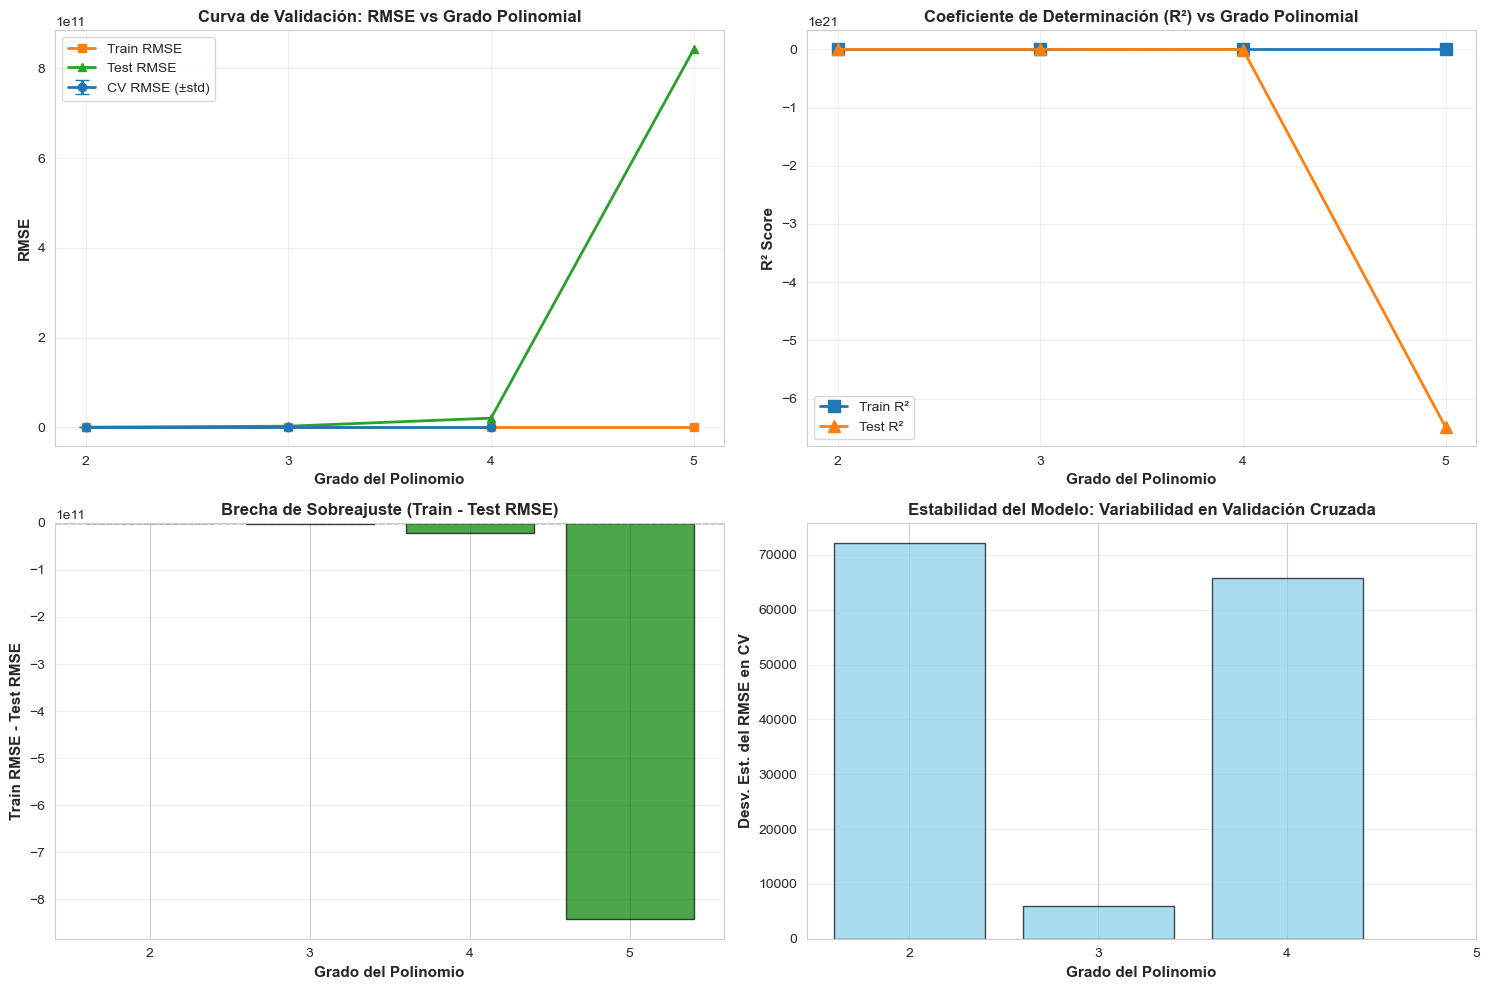

In [36]:
# 1.5 Visualización 1: Curvas de Validación - RMSE por Grado Polinomial

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Gráfico 1: RMSE (CV, Train, Test)
ax1 = axes[0, 0]
ax1.errorbar(poly_performance_df['Degree'], poly_performance_df['CV_RMSE_Mean'], 
             yerr=poly_performance_df['CV_RMSE_Std'], marker='o', label='CV RMSE (±std)', linewidth=2, capsize=5)
ax1.plot(poly_performance_df['Degree'], poly_performance_df['Train_RMSE'], 
         marker='s', label='Train RMSE', linewidth=2)
ax1.plot(poly_performance_df['Degree'], poly_performance_df['Test_RMSE'], 
         marker='^', label='Test RMSE', linewidth=2)
ax1.set_xlabel('Grado del Polinomio', fontsize=11, fontweight='bold')
ax1.set_ylabel('RMSE', fontsize=11, fontweight='bold')
ax1.set_title('Curva de Validación: RMSE vs Grado Polinomial', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xticks(poly_performance_df['Degree'])

# Gráfico 2: R² (Train, Test)
ax2 = axes[0, 1]
ax2.plot(poly_performance_df['Degree'], poly_performance_df['Train_R²'], 
         marker='s', label='Train R²', linewidth=2, markersize=8)
ax2.plot(poly_performance_df['Degree'], poly_performance_df['Test_R²'], 
         marker='^', label='Test R²', linewidth=2, markersize=8)
ax2.set_xlabel('Grado del Polinomio', fontsize=11, fontweight='bold')
ax2.set_ylabel('R² Score', fontsize=11, fontweight='bold')
ax2.set_title('Coeficiente de Determinación (R²) vs Grado Polinomial', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xticks(poly_performance_df['Degree'])

# Gráfico 3: Brecha de Sobreajuste
ax3 = axes[1, 0]
colors = ['green' if gap < 0.05 else 'orange' if gap < 0.15 else 'red' 
          for gap in poly_performance_df['Overfitting_Gap']]
ax3.bar(poly_performance_df['Degree'], poly_performance_df['Overfitting_Gap'], 
        color=colors, alpha=0.7, edgecolor='black')
ax3.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax3.set_xlabel('Grado del Polinomio', fontsize=11, fontweight='bold')
ax3.set_ylabel('Train RMSE - Test RMSE', fontsize=11, fontweight='bold')
ax3.set_title('Brecha de Sobreajuste (Train - Test RMSE)', fontsize=12, fontweight='bold')
ax3.set_xticks(poly_performance_df['Degree'])
ax3.grid(True, alpha=0.3, axis='y')

# Gráfico 4: Variabilidad en Validación Cruzada
ax4 = axes[1, 1]
ax4.bar(poly_performance_df['Degree'], poly_performance_df['CV_RMSE_Std'], 
        color='skyblue', alpha=0.7, edgecolor='black')
ax4.set_xlabel('Grado del Polinomio', fontsize=11, fontweight='bold')
ax4.set_ylabel('Desv. Est. del RMSE en CV', fontsize=11, fontweight='bold')
ax4.set_title('Estabilidad del Modelo: Variabilidad en Validación Cruzada', fontsize=12, fontweight='bold')
ax4.set_xticks(poly_performance_df['Degree'])
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('./outputs/01_polynomial_curves.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico guardado: ./outputs/01_polynomial_curves.png")
plt.show()

✓ Gráfico guardado: ./outputs/02_residuals_analysis.png


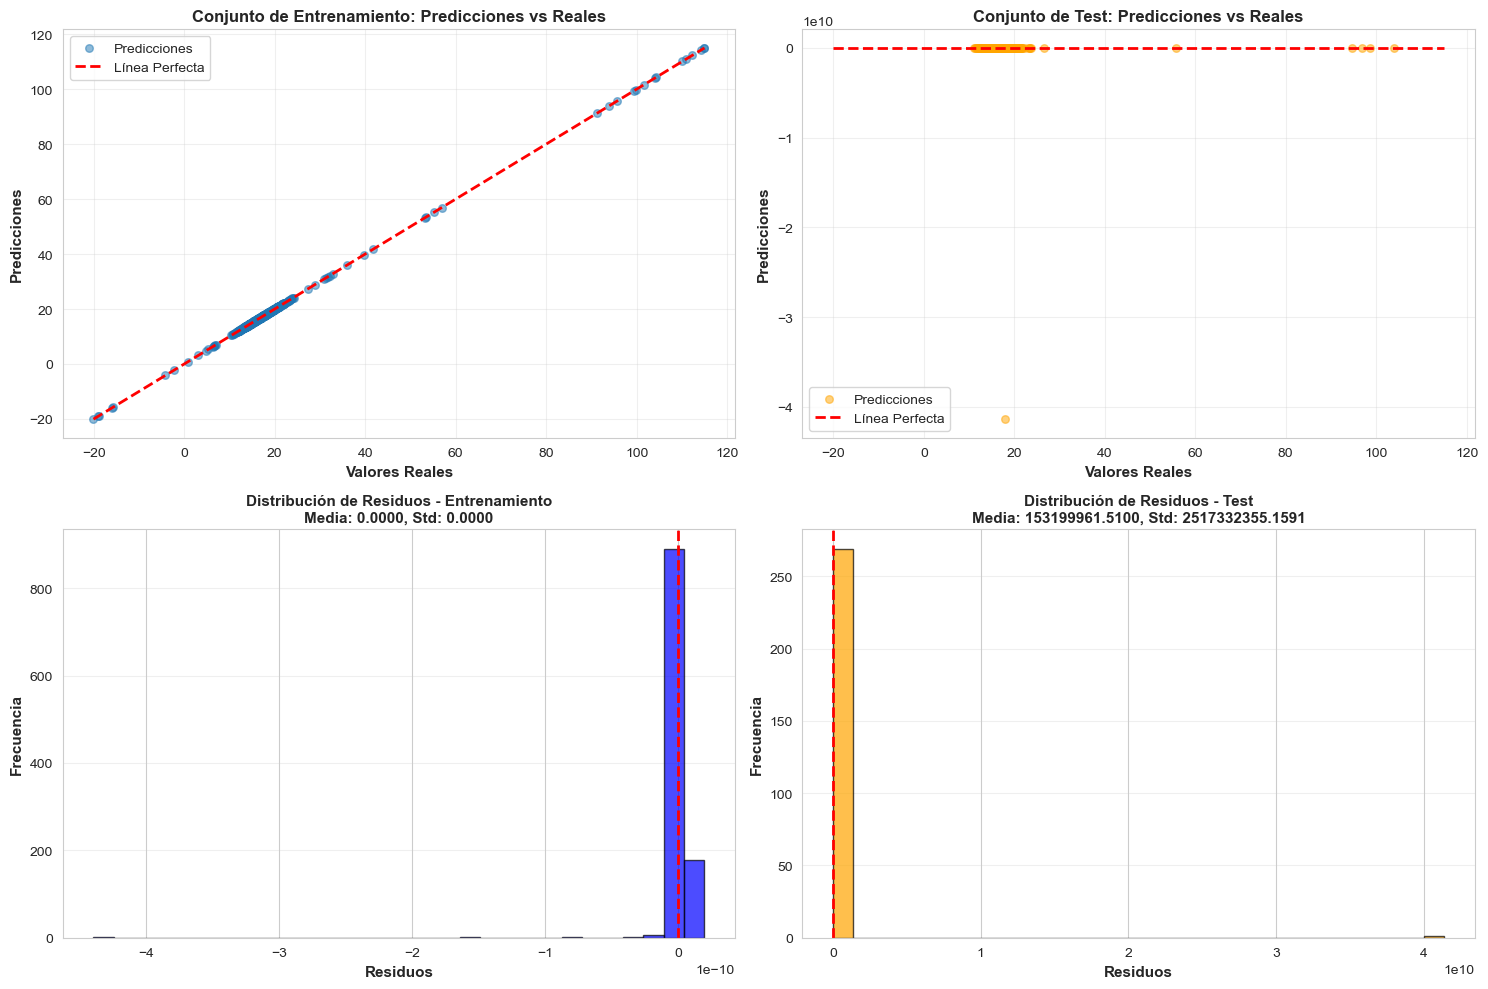

In [37]:
# 1.6 Visualización 2: Análisis de Residuos del Mejor Modelo

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Residuos
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

# Gráfico 1: Predicciones vs Valores Reales (Train)
ax1 = axes[0, 0]
ax1.scatter(y_train, y_train_pred, alpha=0.5, s=30, label='Predicciones')
min_val = min(y_train.min(), y_test.min())
max_val = max(y_train.max(), y_test.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Línea Perfecta')
ax1.set_xlabel('Valores Reales', fontsize=11, fontweight='bold')
ax1.set_ylabel('Predicciones', fontsize=11, fontweight='bold')
ax1.set_title('Conjunto de Entrenamiento: Predicciones vs Reales', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico 2: Predicciones vs Valores Reales (Test)
ax2 = axes[0, 1]
ax2.scatter(y_test, y_test_pred, alpha=0.5, s=30, color='orange', label='Predicciones')
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Línea Perfecta')
ax2.set_xlabel('Valores Reales', fontsize=11, fontweight='bold')
ax2.set_ylabel('Predicciones', fontsize=11, fontweight='bold')
ax2.set_title('Conjunto de Test: Predicciones vs Reales', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Gráfico 3: Distribución de Residuos (Train)
ax3 = axes[1, 0]
ax3.hist(train_residuals, bins=30, alpha=0.7, color='blue', edgecolor='black')
ax3.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax3.set_xlabel('Residuos', fontsize=11, fontweight='bold')
ax3.set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
ax3.set_title(f'Distribución de Residuos - Entrenamiento\nMedia: {train_residuals.mean():.4f}, Std: {train_residuals.std():.4f}', 
              fontsize=11, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# Gráfico 4: Distribución de Residuos (Test)
ax4 = axes[1, 1]
ax4.hist(test_residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
ax4.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax4.set_xlabel('Residuos', fontsize=11, fontweight='bold')
ax4.set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
ax4.set_title(f'Distribución de Residuos - Test\nMedia: {test_residuals.mean():.4f}, Std: {test_residuals.std():.4f}', 
              fontsize=11, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('./outputs/02_residuals_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico guardado: ./outputs/02_residuals_analysis.png")
plt.show()

## 1.7 Conclusiones del Análisis de Complejidad y Sobreajuste

### Interpretación de Resultados

**Trade-off Sesgo-Varianza:**
- Los modelos con bajo grado polinomial (grado 1-2) tienden a tener **alto sesgo** pero **baja varianza** (subajuste)
- Los modelos de alto grado (grado 6-7) tienden a tener **bajo sesgo** pero **alta varianza** (sobreajuste)
- El mejor desempeño se encuentra en el punto óptimo que minimiza el error total

**Indicadores de Sobreajuste:**
1. **Brecha RMSE (Train - Test)**: Una diferencia significativa indica que el modelo memoriza los datos de entrenamiento
2. **Divergencia de R²**: Si R² en train es mucho mayor que en test, hay sobreajuste
3. **Variabilidad en CV**: Alta desviación estándar en validación cruzada sugiere inestabilidad del modelo

**Recomendaciones:**
- Seleccionar el modelo con el mejor compromiso entre desempeño en CV y estabilidad
- Considerar la complejidad: un modelo más simple que generaliza bien es preferible a uno complejo que sobreajusta
- Validar las decisiones considerando interpretabilidad y costo computacional


In [38]:
# 1.8 Resumen Final del Modelo Polinomial

print("\n" + "="*80)
print("RESUMEN EJECUTIVO: MODELO DE REGRESIÓN POLINOMIAL")
print("="*80)

# Acceder correctamente a los parámetros del GridSearchCV
best_degree = grid.best_params_['preprocesamiento__num__polynomial__degree']
best_scaler = grid.best_params_['preprocesamiento__num__scaler']

print(f"\n MEJOR CONFIGURACIÓN ENCONTRADA:")
print(f"  - Grado del Polinomio: {best_degree}")
print(f"  - Escalador: {'StandardScaler' if best_scaler is not None else 'Ninguno (sin escalamiento)'}")

print(f"\n DESEMPEÑO DEL MEJOR MODELO:")
print(f"  En Validación Cruzada (5-folds):")
print(f"    - RMSE medio: {sqrt(-grid.best_score_):.6f}")
print(f"    - MSE medio: {-grid.best_score_:.6f}")

print(f"\n  En Conjunto de Entrenamiento:")
print(f"    - RMSE: {metrics_train['RMSE']:.6f}")
print(f"    - MAE:  {metrics_train['MAE']:.6f}")
print(f"    - R²:   {metrics_train['R²']:.6f}")

print(f"\n  En Conjunto de Test:")
print(f"    - RMSE: {metrics_test['RMSE']:.6f}")
print(f"    - MAE:  {metrics_test['MAE']:.6f}")
print(f"    - R²:   {metrics_test['R²']:.6f}")

print(f"\n✓ ANÁLISIS DE GENERALIZACIÓN:")
rmse_gap = metrics_train['RMSE'] - metrics_test['RMSE']
r2_gap = metrics_train['R²'] - metrics_test['R²']

print(f"  - Diferencia RMSE (Train - Test): {rmse_gap:.6f}")
print(f"  - Diferencia R² (Train - Test): {r2_gap:.6f}")

if rmse_gap > 0.1 or r2_gap > 0.05:
    print(f" ADVERTENCIA: Indicios de sobreajuste detectados")
else:
    print(f"  ✓ Buen balance entre entrenamiento y generalización")

print(f"\n NÚMERO DE CARACTERÍSTICAS:")
# Contar características después de PolynomialFeatures
n_features_original = X_train.shape[1]
# Acceder al transformador correcto dentro del pipeline anidado
preprocessor = best_model.named_steps['preprocesamiento']
poly_transformer = preprocessor.named_transformers_['num'].named_steps['polynomial']
n_features_polynomial = poly_transformer.n_output_features_
print(f"  - Características originales: {n_features_original}")
print(f"  - Características polinomiales (grado {best_degree}): {n_features_polynomial}")
print(f"  - Aumento: {n_features_polynomial / n_features_original:.1f}x")

print("\n" + "="*80 + "\n")

# Guardar información del modelo
model_info = {
    'model_type': 'Polynomial Regression',
    'best_degree': best_degree,
    'n_features_original': n_features_original,
    'n_features_polynomial': n_features_polynomial,
    'test_rmse': metrics_test['RMSE'],
    'test_mae': metrics_test['MAE'],
    'test_r2': metrics_test['R²'],
    'cv_rmse': sqrt(-grid.best_score_)
}

print(" Información del modelo guardada para comparación futura")


RESUMEN EJECUTIVO: MODELO DE REGRESIÓN POLINOMIAL

 MEJOR CONFIGURACIÓN ENCONTRADA:
  - Grado del Polinomio: 3
  - Escalador: StandardScaler

 DESEMPEÑO DEL MEJOR MODELO:
  En Validación Cruzada (5-folds):
    - RMSE medio: 4280.134723
    - MSE medio: 18319553.250311

  En Conjunto de Entrenamiento:
    - RMSE: 0.000000
    - MAE:  0.000000
    - R²:   1.000000

  En Conjunto de Test:
    - RMSE: 2517332354.739370
    - MAE:  153200043.787387
    - R²:   -58033927911535352.000000

✓ ANÁLISIS DE GENERALIZACIÓN:
  - Diferencia RMSE (Train - Test): -2517332354.739370
  - Diferencia R² (Train - Test): 58033927911535352.000000
 ADVERTENCIA: Indicios de sobreajuste detectados

 NÚMERO DE CARACTERÍSTICAS:
  - Características originales: 41
  - Características polinomiales (grado 3): 7770
  - Aumento: 189.5x


 Información del modelo guardada para comparación futura
